# Data

In [ ]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

#plt.style.use('fivethirtyeight')

In [ ]:
df = yf.download('AAPL', start='2012-01-01', end='2023-12-29')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.433821,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.500645,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.639431,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.771559,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.751296,394024400
...,...,...,...,...,...,...
2023-12-21,196.100006,197.080002,193.500000,194.679993,194.431885,46482500
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.353287,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.803986,28919300


# EDA

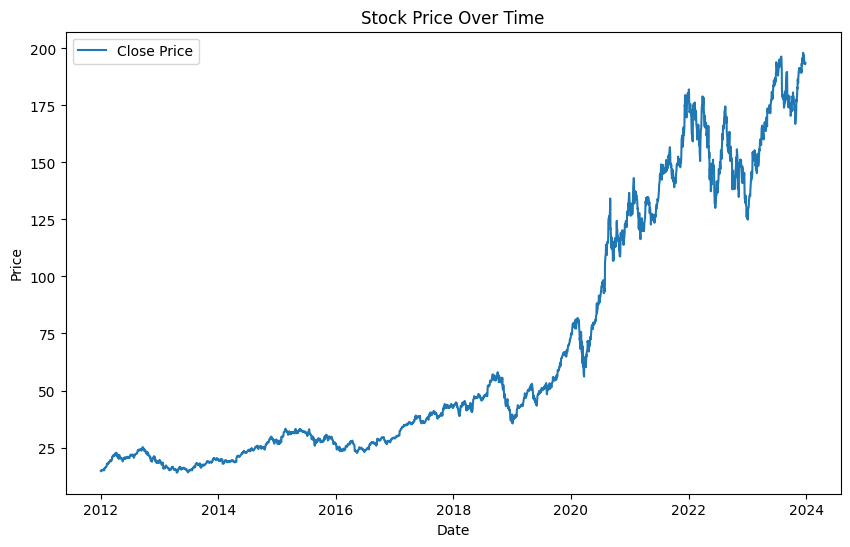

In [ ]:
# Đọc dữ liệu từ DataFrame
# Trực quan hóa dữ liệu
plt.figure(figsize=(10, 6))
plt.plot(df["Close"], label="Close Price")
plt.title("Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
# Tính toán các chỉ số thống kê cơ bản
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3017.000000,3017.000000,3017.000000,3017.000000,3017.000000,3.017000e+03
mean,67.981546,68.717156,67.283567,68.032157,65.889922,1.916457e+08
std,55.786263,56.420674,55.204923,55.845624,56.299965,1.693297e+08
min,13.856071,14.271429,13.753571,13.947500,11.982234,2.404830e+07
25%,24.812500,25.083214,24.600000,24.879999,22.420418,8.680720e+07
50%,41.345001,41.862499,40.869999,41.312500,39.221977,1.301696e+08
75%,123.519997,124.919998,121.839996,123.389999,121.275070,2.306736e+08
max,198.020004,199.619995,197.000000,198.110001,197.857529,1.506120e+09


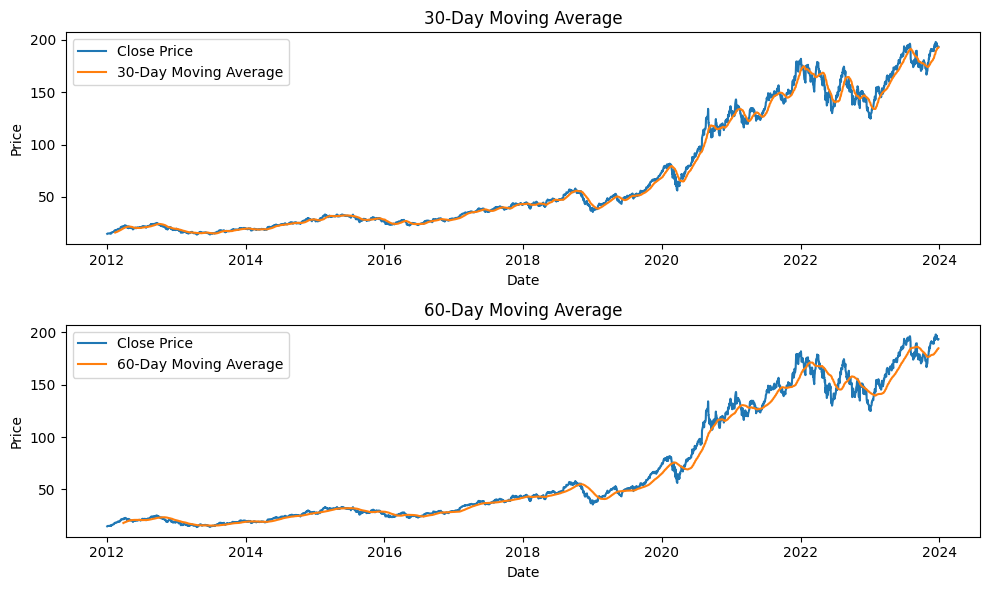

In [ ]:
# Tính toán đường trung bình động
window_size_30 = 30
window_size_60 = 60

df["Moving Average 30"] = df["Close"].rolling(window=window_size_30).mean()
df["Moving Average 60"] = df["Close"].rolling(window=window_size_60).mean()

# Tạo subplot cho mỗi đường trung bình động
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Đồ thị cho đường trung bình động 30 ngày
axs[0].plot(df["Close"], label="Close Price")
axs[0].plot(df["Moving Average 30"], label=f"{window_size_30}-Day Moving Average")
axs[0].set_title(f"{window_size_30}-Day Moving Average")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Price")
axs[0].legend()

# Đồ thị cho đường trung bình động 60 ngày
axs[1].plot(df["Close"], label="Close Price")
axs[1].plot(df["Moving Average 60"], label=f"{window_size_60}-Day Moving Average")
axs[1].set_title(f"{window_size_60}-Day Moving Average")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Price")
axs[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
missing_values = df.isnull().sum()
print(missing_values)

Open                  0
High                  0
Low                   0
Close                 0
Adj Close             0
Volume                0
Moving Average 30    29
Moving Average 60    59
dtype: int64


# Preprocessing data

In [ ]:
df.index = pd.to_datetime(df.index)

In [ ]:
df = df.filter(['Close'])
df

,Close
Date,
2012-01-03,14.686786
2012-01-04,14.765714
2012-01-05,14.929643
2012-01-06,15.085714
2012-01-09,15.061786
...,...
2023-12-21,194.679993
2023-12-22,193.600006
2023-12-26,193.050003


In [ ]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [ ]:
scaled_data

array([[0.00401431],
       [0.00444289],
       [0.00533302],
       ...,
       [0.97252428],
       [0.97306723],
       [0.97540217]])

In [ ]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_data_len = math.ceil(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_data_len, :]
test_data = scaled_data[train_data_len - 30:, :]  # Sử dụng 30 dữ liệu trước đó để dự đoán dữ liệu tiếp theo

In [ ]:
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [ ]:
#example
a = []
b = []
for i in range(30, len(train_data)):
  a.append(train_data[i-30:i,0])
  b.append(train_data[i,0])
  if i<=31:
    print(a)
    print(b)
    print()

[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.00577323, 0.00715207, 0.00579457,
       0.01088518, 0.01049151, 0.01100542, 0.01211663, 0.01278955,
       0.01273332, 0.01252582, 0.01341013, 0.01424207, 0.01518457,
       0.01670691, 0.01990478, 0.01995326, 0.02173353, 0.02306387])]
[0.020777462073654815]

[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.00577323, 0.00715207, 0.00579457,
       0.01088518, 0.01049151, 0.01100542, 0.01211663, 0.01278955,
       0.01273332, 0.01252582, 0.01341013, 0.01424207, 0.01518457,
       0.01670691, 0.01990478, 0.01995326, 0.02173353, 0.02306387]), array([0.00444289, 0.00533302, 0.00618049, 0.00605056, 0.00634339,
       0.00620958, 0.00598462, 0.00567821, 0.00662652, 0.00748175,
       0.007218  , 0.00577323, 0

In [ ]:
time_step = 30  # Số lượng dữ liệu quan sát trong quá khứ
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# **Stacked-LSTM**

In [ ]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) #return_sequences=True cho phép layer trả về chuỗi các giá trị (sequence) thay vì chỉ trả về kết quả cuối cùng
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/100
38/38 [==============================] - 7s 39ms/step - loss: 0.0038 - val_loss: 0.0014
Epoch 2/100
38/38 [==============================] - 0s 12ms/step - loss: 2.4796e-04 - val_loss: 0.0015
Epoch 3/100
38/38 [==============================] - 0s 10ms/step - loss: 1.8207e-04 - val_loss: 0.0013
Epoch 4/100
38/38 [==============================] - 0s 9ms/step - loss: 1.8408e-04 - val_loss: 0.0014
Epoch 5/100
38/38 [==============================] - 0s 9ms/step - loss: 1.7207e-04 - val_loss: 0.0014
Epoch 6/100
38/38 [==============================] - 0s 9ms/step - loss: 1.6151e-04 - val_loss: 0.0024
Epoch 7/100
38/38 [==============================] - 1s 20ms/step - loss: 1.9569e-04 - val_loss: 0.0011
Epoch 8/100
38/38 [==============================] - 0s 9ms/step - loss: 1.6159e-04 - val_loss: 0.0013
Epoch 9/100
38/38 [==============================] - 0s 9ms/step - loss: 1.5479e-04 - val_loss: 0.0013
Epoch 10/100
38/38 [==============================] - 0s 9ms/step - loss:

In [ ]:
loss = model.evaluate(X_test, y_test)
print("Loss:", loss)

19/19 [==============================] - 0s 4ms/step - loss: 2.7176e-04
Loss: 0.0002717554452829063


In [ ]:
predictions = model.predict(X_test)
predicted_price_lstm = scaler.inverse_transform(predictions)

19/19 [==============================] - 0s 3ms/step


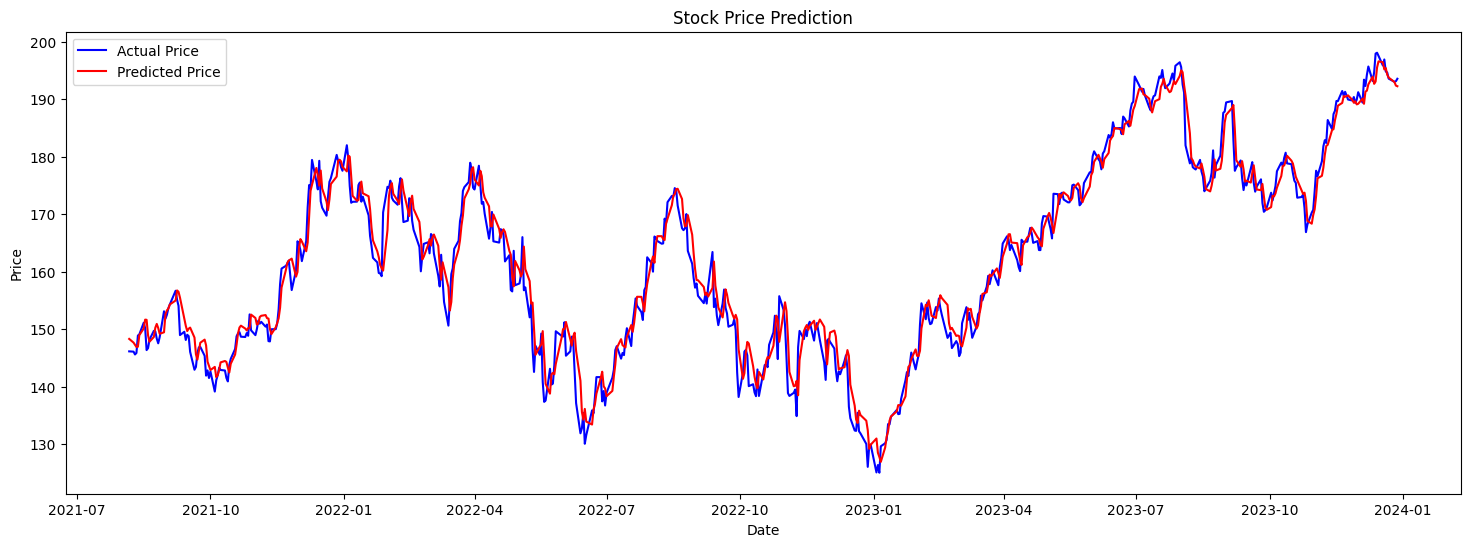

In [ ]:
# Trực quan hóa kết quả dự đoán
plt.figure(figsize=(18, 6))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Price')
plt.plot(df.index[-len(y_test):], predicted_price_lstm, color='red', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Tính toán RMSE từ dữ liệu dự đoán và dữ liệu thực tế
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

RMSE: 0.016485006321752708


## Dự đoán ngày kế tiếp trong data

In [ ]:
stock_data = yf.download('AAPL', start='2023-12-29', end='2023-12-31')
stock_data['Close']

[*********************100%%**********************]  1 of 1 completed


Date
2023-12-29    192.529999
Name: Close, dtype: float64

In [ ]:
last_30_days = scaled_data[-30:]  # Lấy 30 ngày cuối cùng trong dữ liệu
X_new = np.array([last_30_days])  # Tạo mảng 3D cho dự đoán

In [ ]:
predicted_scaled_price = model.predict(X_new)
predicted_price = scaler.inverse_transform(predicted_scaled_price)

1/1 [==============================] - 0s 18ms/step


In [ ]:
print("Dự đoán giá cổ phiếu cho ngày 30/12/2023:", predicted_price[0][0])

Dự đoán giá cổ phiếu cho ngày 30/12/2023: 192.5474


# **Bi-LSTM**

In [ ]:
from keras.layers import Bidirectional

# Xây dựng mô hình Bi-LSTM
model_Bi = Sequential()
model_Bi.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1], 1))) #return_sequences=True cho phép layer trả về chuỗi các giá trị (sequence) thay vì chỉ trả về kết quả cuối cùng
model_Bi.add(Bidirectional(LSTM(50, return_sequences=False)))
model_Bi.add(Dense(25))
model_Bi.add(Dense(1))
model_Bi.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history_Bi = model_Bi.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/100
38/38 [==============================] - 9s 65ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 2/100
38/38 [==============================] - 1s 20ms/step - loss: 2.6724e-04 - val_loss: 0.0016
Epoch 3/100
38/38 [==============================] - 1s 13ms/step - loss: 2.2923e-04 - val_loss: 0.0015
Epoch 4/100
38/38 [==============================] - 1s 22ms/step - loss: 2.1232e-04 - val_loss: 0.0017
Epoch 5/100
38/38 [==============================] - 0s 12ms/step - loss: 2.0136e-04 - val_loss: 0.0012
Epoch 6/100
38/38 [==============================] - 0s 13ms/step - loss: 1.7669e-04 - val_loss: 0.0011
Epoch 7/100
38/38 [==============================] - 1s 13ms/step - loss: 1.5762e-04 - val_loss: 0.0010
Epoch 8/100
38/38 [==============================] - 1s 18ms/step - loss: 1.5368e-04 - val_loss: 0.0016
Epoch 9/100
38/38 [==============================] - 1s 19ms/step - loss: 1.7003e-04 - val_loss: 8.2594e-04
Epoch 10/100
38/38 [==============================] - 1s 18ms/st

In [ ]:
loss = model_Bi.evaluate(X_test, y_test)
print("Loss:", loss)

19/19 [==============================] - 0s 5ms/step - loss: 2.7794e-04
Loss: 0.000277943501714617


In [ ]:
predictions = model_Bi.predict(X_test)
predicted_price_bi = scaler.inverse_transform(predictions)

19/19 [==============================] - 2s 6ms/step


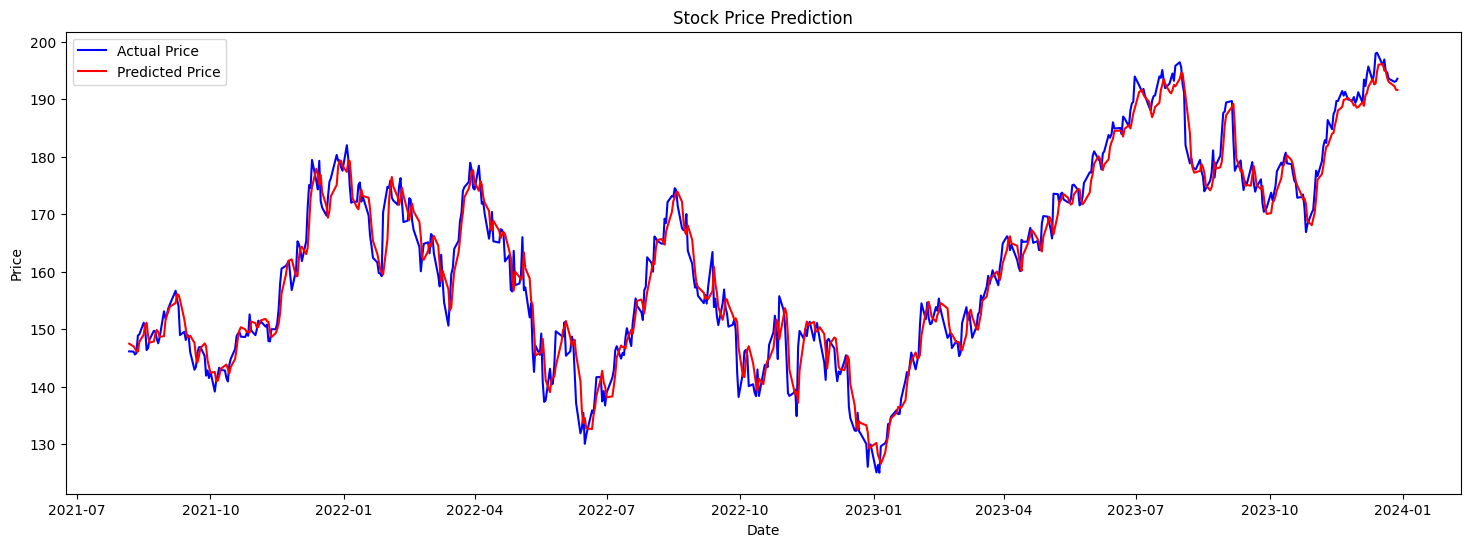

In [ ]:
# Trực quan hóa kết quả dự đoán
plt.figure(figsize=(18, 6))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Price')
plt.plot(df.index[-len(y_test):], predicted_price_bi, color='red', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Tính toán RMSE từ dữ liệu dự đoán và dữ liệu thực tế
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

RMSE: 0.016671637419989692


## Dự đoán ngày kế tiếp trong data

In [ ]:
stock_data = yf.download('AAPL', start='2023-12-29', end='2023-12-31')
stock_data['Close']

[*********************100%%**********************]  1 of 1 completed


Date
2023-12-29    192.529999
Name: Close, dtype: float64

In [ ]:
last_30_days = scaled_data[-30:]  # Lấy 30 ngày cuối cùng trong dữ liệu
X_new = np.array([last_30_days])  # Tạo mảng 3D cho dự đoán

In [ ]:
predicted_scaled_price = model_Bi.predict(X_new)
predicted_price = scaler.inverse_transform(predicted_scaled_price)

1/1 [==============================] - 0s 23ms/step


In [ ]:
print("Dự đoán giá cổ phiếu cho ngày 30/12/2023:", predicted_price[0][0])

Dự đoán giá cổ phiếu cho ngày 30/12/2023: 192.02298


# **RNN**

In [ ]:
from keras.layers import SimpleRNN

# Xây dựng mô hình RNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) #return_sequences=True cho phép layer trả về chuỗi các giá trị (sequence) thay vì chỉ trả về kết quả cuối cùng
model_rnn.add(SimpleRNN(50, return_sequences=False))
model_rnn.add(Dense(25))# linear
model_rnn.add(Dense(1))

# Biên soạn và huấn luyện mô hình
model_rnn.compile(optimizer='adam', loss='mean_squared_error')
history_rnn = model_rnn.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/100
38/38 [==============================] - 4s 54ms/step - loss: 0.0083 - val_loss: 0.0122
Epoch 2/100
38/38 [==============================] - 4s 120ms/step - loss: 2.8099e-04 - val_loss: 0.0086
Epoch 3/100
38/38 [==============================] - 3s 74ms/step - loss: 2.1526e-04 - val_loss: 0.0081
Epoch 4/100
38/38 [==============================] - 2s 47ms/step - loss: 1.9309e-04 - val_loss: 0.0067
Epoch 5/100
38/38 [==============================] - 2s 47ms/step - loss: 1.7034e-04 - val_loss: 0.0039
Epoch 6/100
38/38 [==============================] - 3s 75ms/step - loss: 1.7751e-04 - val_loss: 0.0041
Epoch 7/100
38/38 [==============================] - 3s 74ms/step - loss: 1.6388e-04 - val_loss: 0.0048
Epoch 8/100
38/38 [==============================] - 3s 70ms/step - loss: 1.3222e-04 - val_loss: 0.0031
Epoch 9/100
38/38 [==============================] - 2s 51ms/step - loss: 1.3878e-04 - val_loss: 0.0044
Epoch 10/100
38/38 [==============================] - 2s 45ms/step 

In [ ]:
# Đánh giá mô hình
loss = model_rnn.evaluate(X_test, y_test)
print("Loss:", loss)

19/19 [==============================] - 0s 7ms/step - loss: 4.2036e-04
Loss: 0.0004203602147754282


In [ ]:
predictions = model_rnn.predict(X_test)
predicted_price_rnn = scaler.inverse_transform(predictions)

19/19 [==============================] - 0s 7ms/step


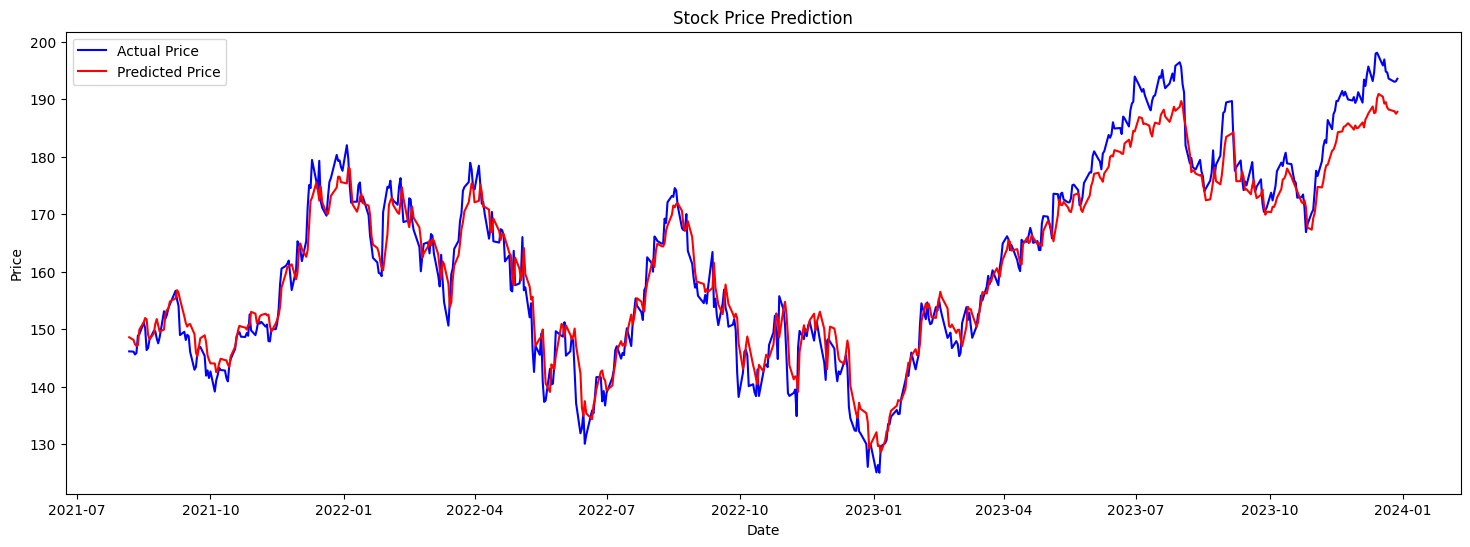

In [ ]:
# Trực quan hóa kết quả dự đoán
plt.figure(figsize=(18, 6))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Price')
plt.plot(df.index[-len(y_test):], predicted_price_rnn, color='red', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Tính toán RMSE từ dữ liệu dự đoán và dữ liệu thực tế
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

RMSE: 0.020502686298288775


# **CNN + LSTM**

In [ ]:
from keras.layers import Conv1D, Flatten
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1))) # lớp tích chập một chiều, lớp filters sẽ học 64 đặc trưng khác nhau từ dữ liệu đầu vào, phép tích chập sẽ xem xét 3 phần tử liên tiếp mỗi lần
model_cnn_lstm.add(LSTM(50, return_sequences=True))
model_cnn_lstm.add(Flatten()) #làm phẳng đầu ra của lớp lstm trước đó
model_cnn_lstm.add(Dense(25))
model_cnn_lstm.add(Dense(1))

model_cnn_lstm.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/100
38/38 [==============================] - 5s 23ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 2/100
38/38 [==============================] - 0s 6ms/step - loss: 4.1766e-04 - val_loss: 0.0022
Epoch 3/100
38/38 [==============================] - 0s 6ms/step - loss: 3.3210e-04 - val_loss: 0.0021
Epoch 4/100
38/38 [==============================] - 0s 8ms/step - loss: 2.9430e-04 - val_loss: 0.0019
Epoch 5/100
38/38 [==============================] - 0s 8ms/step - loss: 2.3650e-04 - val_loss: 0.0015
Epoch 6/100
38/38 [==============================] - 0s 7ms/step - loss: 2.8540e-04 - val_loss: 0.0014
Epoch 7/100
38/38 [==============================] - 0s 6ms/step - loss: 1.9480e-04 - val_loss: 0.0022
Epoch 8/100
38/38 [==============================] - 0s 8ms/step - loss: 1.7254e-04 - val_loss: 9.9995e-04
Epoch 9/100
38/38 [==============================] - 0s 6ms/step - loss: 1.6721e-04 - val_loss: 0.0010
Epoch 10/100
38/38 [==============================] - 0s 7ms/step - loss

In [ ]:
# Đánh giá mô hình
loss = model_cnn_lstm.evaluate(X_test, y_test)
print("Loss:", loss)

19/19 [==============================] - 0s 3ms/step - loss: 3.7415e-04
Loss: 0.0003741508990060538


In [ ]:
predictions = model_cnn_lstm.predict(X_test)
predicted_price_cnn_lstm = scaler.inverse_transform(predictions)

19/19 [==============================] - 0s 3ms/step


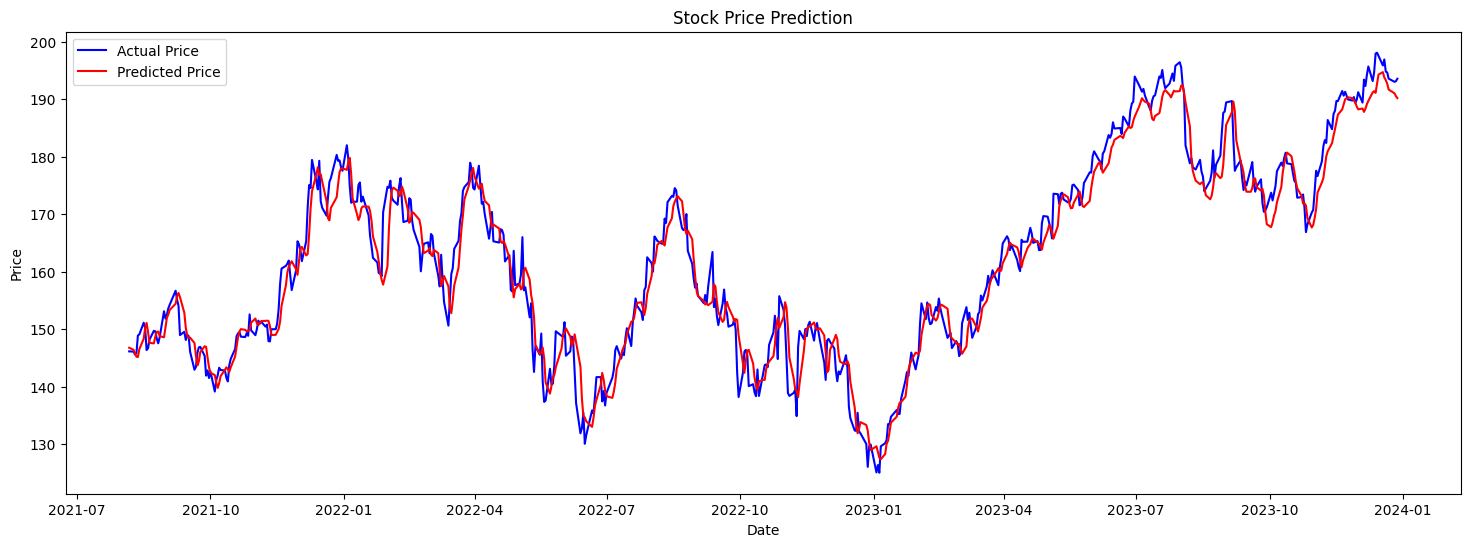

In [ ]:
# Trực quan hóa kết quả dự đoán
plt.figure(figsize=(18, 6))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Price')
plt.plot(df.index[-len(y_test):], predicted_price_cnn_lstm, color='red', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Tính toán RMSE từ dữ liệu dự đoán và dữ liệu thực tế
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

RMSE: 0.01934298087285721


# **CNN**

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))  # Output layer với activation là linear để dự đoán giá

model_cnn.compile(optimizer='adam', loss='mse')

In [ ]:
model_cnn.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/100
75/75 [==============================] - 2s 8ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 2/100
75/75 [==============================] - 0s 6ms/step - loss: 3.8144e-04 - val_loss: 0.0032
Epoch 3/100
75/75 [==============================] - 0s 5ms/step - loss: 3.6062e-04 - val_loss: 0.0032
Epoch 4/100
75/75 [==============================] - 0s 6ms/step - loss: 2.7178e-04 - val_loss: 0.0025
Epoch 5/100
75/75 [==============================] - 0s 6ms/step - loss: 2.4986e-04 - val_loss: 0.0020
Epoch 6/100
75/75 [==============================] - 0s 4ms/step - loss: 2.1601e-04 - val_loss: 0.0013
Epoch 7/100
75/75 [==============================] - 0s 4ms/step - loss: 2.5368e-04 - val_loss: 0.0017
Epoch 8/100
75/75 [==============================] - 0s 4ms/step - loss: 1.6709e-04 - val_loss: 0.0015
Epoch 9/100
75/75 [==============================] - 0s 4ms/step - loss: 1.5919e-04 - val_loss: 8.9429e-04
Epoch 10/100
75/75 [==============================] - 0s 4ms/step - loss:

In [ ]:
# Đánh giá mô hình trên tập kiểm tra
loss = model_cnn.evaluate(X_test, y_test)
print("Test Loss:", loss)

19/19 [==============================] - 0s 2ms/step - loss: 3.9935e-04
Test Loss: 0.00039935330278240144


In [ ]:
predictions = model_cnn.predict(X_test)
predicted_price_cnn = scaler.inverse_transform(predictions)

19/19 [==============================] - 0s 2ms/step


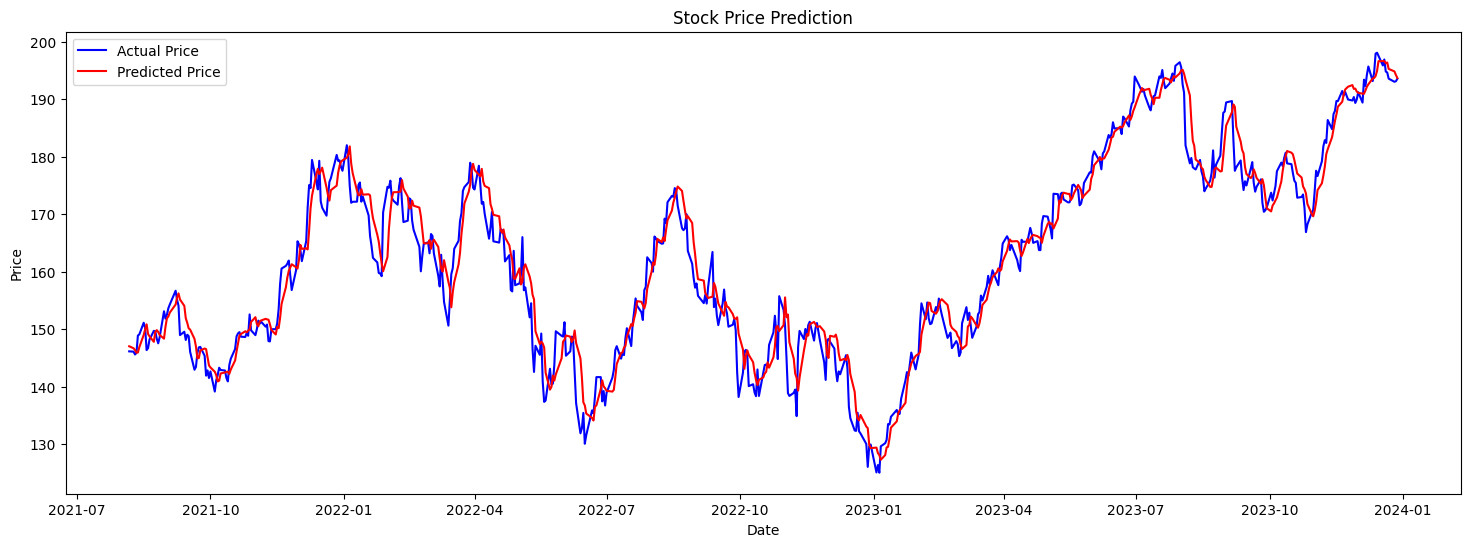

In [ ]:
# Trực quan hóa kết quả dự đoán
plt.figure(figsize=(18, 6))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Price')
plt.plot(df.index[-len(y_test):], predicted_price_cnn, color='red', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Tính toán RMSE từ dữ liệu dự đoán và dữ liệu thực tế
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

RMSE: 0.019983825436000517


# **GRU**

In [ ]:
import tensorflow as tf

model_gru = tf.keras.Sequential([
    tf.keras.layers.GRU(units=64, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(units=1)
])

model_gru.compile(optimizer='adam', loss='mean_squared_error')
model_gru.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/100
75/75 [==============================] - 4s 12ms/step - loss: 0.0049 - val_loss: 5.3741e-04
Epoch 2/100
75/75 [==============================] - 0s 5ms/step - loss: 7.9478e-05 - val_loss: 5.2710e-04
Epoch 3/100
75/75 [==============================] - 0s 6ms/step - loss: 7.4629e-05 - val_loss: 4.5962e-04
Epoch 4/100
75/75 [==============================] - 0s 5ms/step - loss: 7.2423e-05 - val_loss: 4.9616e-04
Epoch 5/100
75/75 [==============================] - 0s 5ms/step - loss: 7.0849e-05 - val_loss: 4.2210e-04
Epoch 6/100
75/75 [==============================] - 1s 8ms/step - loss: 6.6640e-05 - val_loss: 3.9603e-04
Epoch 7/100
75/75 [==============================] - 1s 7ms/step - loss: 6.5309e-05 - val_loss: 3.8560e-04
Epoch 8/100
75/75 [==============================] - 1s 8ms/step - loss: 6.2582e-05 - val_loss: 4.0363e-04
Epoch 9/100
75/75 [==============================] - 1s 7ms/step - loss: 5.9334e-05 - val_loss: 3.9959e-04
Epoch 10/100
75/75 [====================

In [ ]:
loss = model_gru.evaluate(X_test, y_test)
print("Test Loss:", loss)

19/19 [==============================] - 0s 3ms/step - loss: 2.3282e-04
Test Loss: 0.00023282310576178133


In [ ]:
predictions = model_gru.predict(X_test)
predicted_price_gru = scaler.inverse_transform(predictions)

19/19 [==============================] - 1s 3ms/step


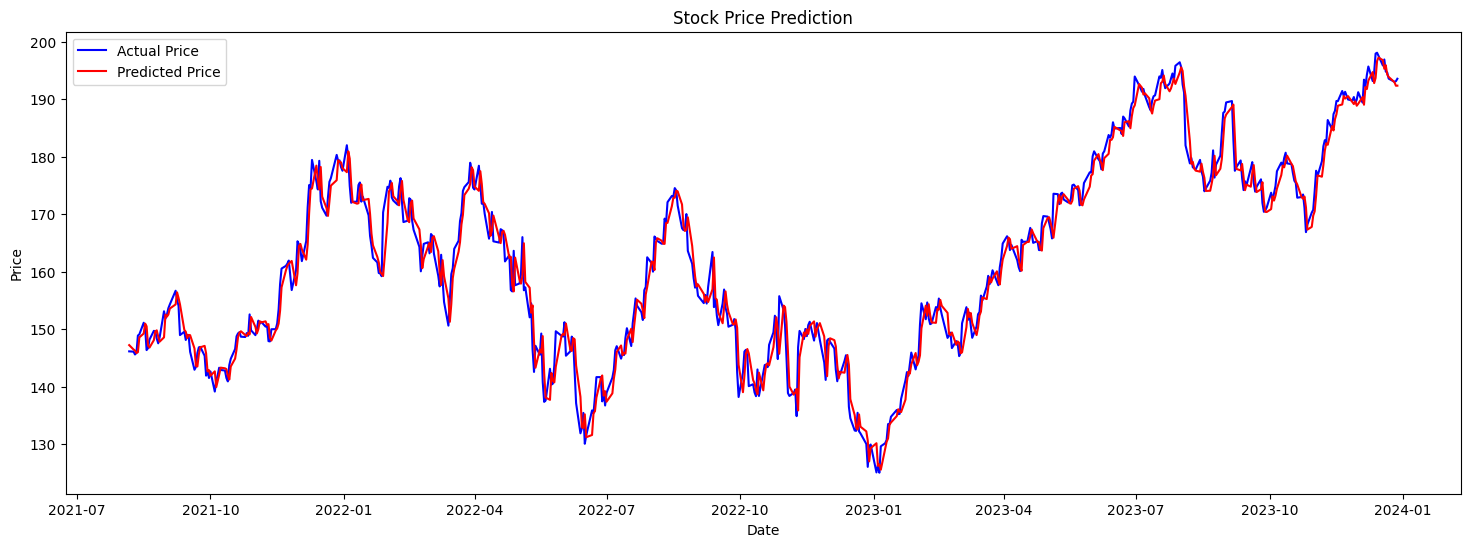

In [ ]:
# Trực quan hóa kết quả dự đoán
plt.figure(figsize=(18, 6))
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Price')
plt.plot(df.index[-len(y_test):], predicted_price_gru, color='red', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Tính toán RMSE từ dữ liệu dự đoán và dữ liệu thực tế
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE:", rmse)

RMSE: 0.01525854089936095


# **Compare**

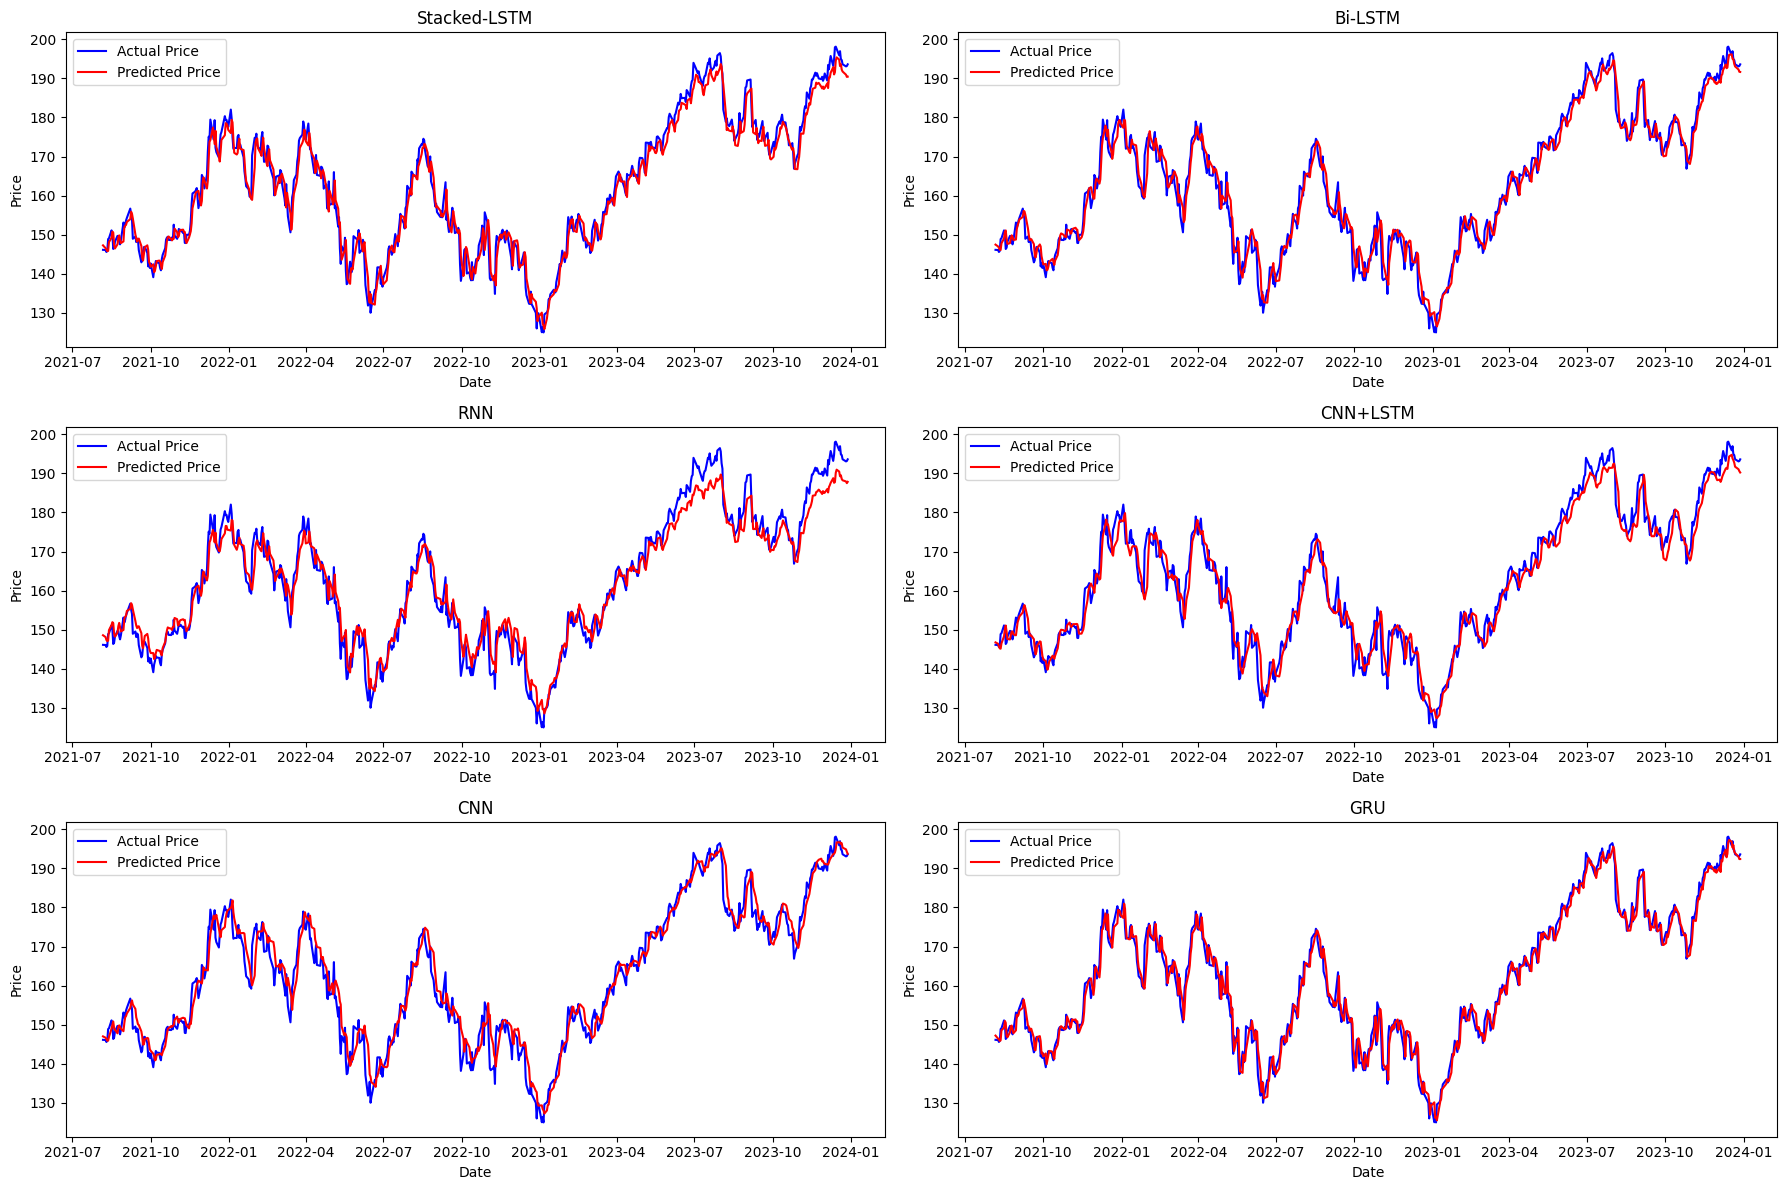

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 2, figsize=(18, 12))

axs[0, 0].plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Price')
axs[0, 0].plot(df.index[-len(y_test):], predicted_price_lstm, color='red', label='Predicted Price')
axs[0, 0].set_title('Stacked-LSTM')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Price')
axs[0, 0].legend()

axs[0, 1].plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Price')
axs[0, 1].plot(df.index[-len(y_test):], predicted_price_bi, color='red', label='Predicted Price')
axs[0, 1].set_title('Bi-LSTM')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Price')
axs[0, 1].legend()

axs[1, 0].plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Price')
axs[1, 0].plot(df.index[-len(y_test):], predicted_price_rnn, color='red', label='Predicted Price')
axs[1, 0].set_title('RNN')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Price')
axs[1, 0].legend()

axs[1, 1].plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Price')
axs[1, 1].plot(df.index[-len(y_test):], predicted_price_cnn_lstm, color='red', label='Predicted Price')
axs[1, 1].set_title('CNN+LSTM')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Price')
axs[1, 1].legend()

axs[2, 0].plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Price')
axs[2, 0].plot(df.index[-len(y_test):], predicted_price_cnn, color='red', label='Predicted Price')
axs[2, 0].set_title('CNN')
axs[2, 0].set_xlabel('Date')
axs[2, 0].set_ylabel('Price')
axs[2, 0].legend()

axs[2, 1].plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), color='blue', label='Actual Price')
axs[2, 1].plot(df.index[-len(y_test):], predicted_price_gru, color='red', label='Predicted Price')
axs[2, 1].set_title('GRU')
axs[2, 1].set_xlabel('Date')
axs[2, 1].set_ylabel('Price')
axs[2, 1].legend()

#axs[2, 1].remove()
plt.tight_layout()
plt.show()


# RMSE của MODEL



*   Stacked-LSTM: ---- 0.016485006321752708
*   Bi-LSTM:   -------------  0.016671637419989692
*   RNN:       ------------------   0.020502686298288775
*   CNN+LSTM:   -------  0.01934298087285721
*   CNN:----------------- 0.019983825436000517
*   GRU:----------------- **0.01525854089936095**

---

